<a href="https://colab.research.google.com/github/IverMartinsen/uncertainty/blob/main/cifar10_psgld.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_datasets as tfds

In [4]:
import tensorflow as tf
from tensorflow_probability.python.math.diag_jacobian import diag_jacobian


class pSGLangevinDynamics(tf.keras.optimizers.Optimizer):
    """
    Preconditioned Stochastic Gradient Langevin Dynamics
    """
    def __init__(
        self,
        learning_rate=0.001,
        rho=0.9,
        epsilon=1e-7,
        data_size=1,
        burnin=0,
        parallel_iterations=10,
        include_gamma_term=False,
        jit_compile=True,
        name="pSGLD",
        **kwargs
    ):
        super().__init__(
            jit_compile=jit_compile,
            name=name,
            **kwargs
        )
        self.rho = rho # alpha parameter in preconditioner decay rate (alpha)
        self.epsilon = epsilon # diagonal bias (lambda)
        self.include_gamma_term = include_gamma_term
        self._data_size = tf.convert_to_tensor(data_size, name='data_size')
        self._burnin = tf.convert_to_tensor(burnin, name='burnin')
        self._learning_rate = self._build_learning_rate(learning_rate)
        self._parallel_iterations = parallel_iterations

    def build(self, var_list):
        super().build(var_list)
        if hasattr(self, "_built") and self._built:
            return
        self._built = True

        self._velocities = []
        for var in var_list:
            self._velocities.append(
                self.add_variable_from_reference(var, "velocity")
            )

    def update_step(self, gradient, variable):
        """Update step given gradient and the associated model variable."""
        lr = tf.cast(self.learning_rate, variable.dtype)

        stddev = tf.where(
            tf.squeeze(self.iterations > tf.cast(self._burnin, tf.int64)),
            tf.cast(tf.math.rsqrt(lr), gradient.dtype),
            tf.zeros([], gradient.dtype)
            )

        rho = self.rho

        var_key = self._var_key(variable)
        velocity = self._velocities[self._index_dict[var_key]]

        if isinstance(gradient, tf.IndexedSlices):
            # Sparse gradients.
            velocity.assign(rho * velocity)
            velocity.scatter_add(
                tf.IndexedSlices(
                    tf.square(gradient.values) * (1 - rho), gradient.indices
                )
            )
            denominator = velocity + self.epsilon
            denominator_slices = tf.gather(denominator, gradient.indices)
            preconditioner = tf.math.rsqrt(denominator_slices)
            if self.include_gamma_term:
                _, preconditioner_grads = diag_jacobian(xs=variable, ys=preconditioner, parallel_iterations=self._parallel_iterations)
                mean = 0.5 * (preconditioner * gradient * tf.cast(self._data_size, gradient.dtype) - preconditioner_grads[0])
            else:
                mean = 0.5 * (preconditioner * gradient * tf.cast(self._data_size, gradient.dtype))
            stddev *= tf.sqrt(preconditioner)
            result_shape = tf.broadcast_dynamic_shape(tf.shape(mean), tf.shape(stddev))
            noisy_grad = tf.random.normal(shape=result_shape, mean=mean, stddev=stddev, dtype=gradient.dtype)

            increment = tf.IndexedSlices(
                lr * noisy_grad,
                gradient.indices,
            )

            variable.scatter_add(-increment)
        else:
            # Dense gradients.
            velocity.assign(rho * velocity + (1 - rho) * tf.square(gradient))
            denominator = velocity + self.epsilon
            preconditioner = tf.math.rsqrt(denominator)
            if self.include_gamma_term:
                _, preconditioner_grads = diag_jacobian(xs=variable, ys=preconditioner, parallel_iterations=self._parallel_iterations)
                mean = 0.5 * (preconditioner * gradient * tf.cast(self._data_size, gradient.dtype) - preconditioner_grads[0])
            else:
                mean = 0.5 * (preconditioner * gradient * tf.cast(self._data_size, gradient.dtype))
            stddev *= tf.sqrt(preconditioner)
            result_shape = tf.broadcast_dynamic_shape(tf.shape(mean), tf.shape(stddev))
            noisy_grad = tf.random.normal(shape=result_shape, mean=mean, stddev=stddev, dtype=gradient.dtype)

            increment = lr * noisy_grad
            variable.assign_add(-increment)

    def get_config(self):
        config = super().get_config()

        config.update(
            {
                "learning_rate": self._serialize_hyperparameter(
                    self._learning_rate
                ),
                "rho": self.rho,
                "epsilon": self.epsilon,
            }
        )
        return config


In [8]:
batch_size = 512

ds_train, ds_test = tfds.load('cifar10', split=['train', 'test'], shuffle_files=True, as_supervised=True, batch_size=batch_size)

n = 50000 # sample size

epochs = 100

# adding a prior to the weights
regularizer = tf.keras.regularizers.l2(0.01)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3), padding='same', kernel_regularizer=regularizer, bias_regularizer=regularizer),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizer, bias_regularizer=regularizer),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizer, bias_regularizer=regularizer),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax', kernel_regularizer=regularizer, bias_regularizer=regularizer)
])


class InverseTimeDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_learning_rate, decay_steps, decay_rate):
        super().__init__()
        self.initial_learning_rate = tf.cast(initial_learning_rate, tf.float32)
        self.decay_steps = tf.cast(decay_steps, tf.float32)
        self.decay_rate = tf.cast(decay_rate, tf.float32)

    @tf.function
    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        lr = self.initial_learning_rate / (1 + self.decay_rate * step / self.decay_steps)
        return tf.cast(lr, tf.float32)


lr_schedule = InverseTimeDecay(
    initial_learning_rate=0.01 / n,
    decay_steps=epochs*n//(batch_size),
    decay_rate=1.0
)

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.001 / n,
    decay_steps=epochs*n//(batch_size),
    decay_rate=0.9,
    staircase=False
)



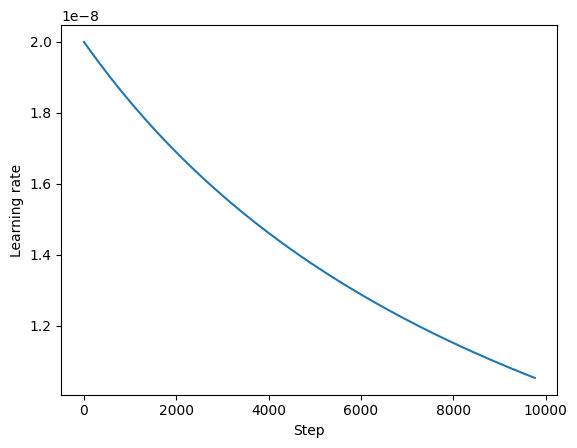

In [6]:
import matplotlib.pyplot as plt
import numpy as np



plt.plot(lr_schedule(tf.range(epochs*n//batch_size)))
plt.ylabel("Learning rate")
plt.xlabel("Step")
plt.show()


In [3]:



optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model.fit(ds_train, epochs=epochs, validation_data=ds_test, shuffle=True)

Train on 98 steps, validate on 20 steps
Epoch 1/100
26/98 [======>.......................] - ETA: 6s - batch: 12.5000 - size: 1.0000 - loss: 74.2930 - accuracy: 0.0994

KeyboardInterrupt: ignored

In [9]:


diagonal_bias = 1e-8 # lambda parameter in the paper (slightly different implementation)

preconditioner_decay_rate = 0.99 # alpha parameter in the paper
burnin = 10 * n // batch_size # number of training steps before starting to add gradient noise



optimizer = pSGLangevinDynamics(burnin=burnin, rho=preconditioner_decay_rate, data_size=n, learning_rate=lr_schedule, parallel_iterations=1)

#optimizer = tfp.optimizer.StochasticGradientLangevinDynamics(learning_rate=1, preconditioner_decay_rate=preconditioner_decay_rate, diagonal_bias=diagonal_bias, burnin=burnin, data_size=n)
#optimizer._learning_rate = optimizer._build_learning_rate(0.01)


loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)


# callback to record parameters
class RecordParametersCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.parameters = []
    def on_epoch_end(self, epoch, logs=None):
        self.parameters.append(model.get_weights())


model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])


callback = RecordParametersCallback()

model.fit(ds_train, epochs=epochs, validation_data=ds_test, callbacks=[callback], shuffle=True)


Epoch 1/100
98/98 [==============================] - 12s 98ms/step - loss: 8711.0977 - accuracy: 0.0978 - val_loss: 464.9618 - val_accuracy: 0.1000
Epoch 2/100
98/98 [==============================] - 2s 17ms/step - loss: 141.8203 - accuracy: 0.0975 - val_loss: 26.5780 - val_accuracy: 0.1000
Epoch 3/100
98/98 [==============================] - 2s 19ms/step - loss: 10.7375 - accuracy: 0.1012 - val_loss: 3.6802 - val_accuracy: 0.1000
Epoch 4/100
98/98 [==============================] - 2s 16ms/step - loss: 2.8594 - accuracy: 0.1008 - val_loss: 2.6227 - val_accuracy: 0.1000
Epoch 5/100
98/98 [==============================] - 2s 16ms/step - loss: 2.6646 - accuracy: 0.0987 - val_loss: 2.7118 - val_accuracy: 0.1000
Epoch 6/100
98/98 [==============================] - 2s 17ms/step - loss: 2.7916 - accuracy: 0.0987 - val_loss: 2.8639 - val_accuracy: 0.1000
Epoch 7/100
98/98 [==============================] - 2s 18ms/step - loss: 2.9481 - accuracy: 0.0986 - val_loss: 3.0241 - val_accuracy: 0.1

KeyboardInterrupt: ignored

In [15]:
parameters = callback.parameters

In [17]:
len(parameters)

69